# Hierarchical and Aglomerative clustering

### Import libraries

In [2]:
# import all libraries used in this notebook here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

#import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = 'notebook'



In this exercise, we will perform hierarchical clustering with the [APP User Behavior dataset](https://www.kaggle.com/datasets/bhanupratapbiswas/app-users-segmentation-case-study). Please download `App_User_Behavior.csv` from the Learn platform.

This dataset records a list of features that characterize the user behavior when using an app.

We will perform clustering with this dataset to build a hierarchy of clusters among different users based on their behavior pattern.

### Task 1. Load and explore the dataset

<span style="color:red">**[TBC]**</span> Load the dataset and perform data exploration to see if there is a need for:
- Eliminate records with missing-values
- Eliminate highly correlated features
- Eliminate irrelevant / useless features
- Feature scaling
- Eliminate outliers

In [5]:
# [TBC] complete your code here with proper comments
# load dataset
df = pd.read_csv('App_User_Behavior.csv')
df.head()

userid  Average Screen Time  Average Spent on App (INR)  Left Review  \
0    1001                 17.0                       634.0            1   
1    1002                  0.0                        54.0            0   
2    1003                 37.0                       207.0            0   
3    1004                 32.0                       445.0            1   
4    1005                 45.0                       427.0            1   

   Ratings  New Password Request  Last Visited Minutes       Status  
0        9                     7                  2990    Installed  
1        4                     8                 24008  Uninstalled  
2        8                     5                   971    Installed  
3        6                     2                   799    Installed  
4        5                     6                  3668    Installed

### Task 2. Data pre-processing

<span style="color:red">**[TBC]**</span> Depending on the conclusions you got from data exploration, preproces the dataset.

In [6]:
# [TBC] complete your code here with proper comments
# set 'CustomerID' as the index of the DataFrame
df.set_index(['userid'], inplace = True)
df.head()

Average Screen Time  Average Spent on App (INR)  Left Review  Ratings  \
userid                                                                          
1001                   17.0                       634.0            1        9   
1002                    0.0                        54.0            0        4   
1003                   37.0                       207.0            0        8   
1004                   32.0                       445.0            1        6   
1005                   45.0                       427.0            1        5   

        New Password Request  Last Visited Minutes       Status  
userid                                                           
1001                       7                  2990    Installed  
1002                       8                 24008  Uninstalled  
1003                       5                   971    Installed  
1004                       2                   799    Installed  
1005                       6                  3668    Installed

In [8]:
# Convert 'Status' column values to 1 and 0
df['Status'] = df['Status'].replace({'Installed': 1, 'Uninstalled': 0})


In [11]:
# display the correlation matrix between numeric variables
corr = df.corr(numeric_only = True)
corr.style.background_gradient(cmap = 'coolwarm')

In [12]:
correlation_matrix = df.corr()
# You can set a threshold for correlation values and remove features with high correlation
threshold = 0.7  # Adjust this threshold as needed
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

df.drop(highly_correlated_features, axis=1, inplace=True)

In [13]:
df

Average Screen Time  Average Spent on App (INR)  Left Review  Ratings  \
userid                                                                          
1001                   17.0                       634.0            1        9   
1002                    0.0                        54.0            0        4   
1003                   37.0                       207.0            0        8   
1004                   32.0                       445.0            1        6   
1005                   45.0                       427.0            1        5   
...                     ...                         ...          ...      ...   
1995                   38.0                       938.0            0        5   
1996                   43.0                        61.0            0        6   
1997                   47.0                       761.0            0        6   
1998                    6.0                        73.0            1        5   
1999                    9.0                        54.0            0        4   

        New Password Request  Last Visited Minutes  
userid                                              
1001                       7                  2990  
1002                       8                 24008  
1003                       5                   971  
1004                       2                   799  
1005                       6                  3668  
...                      ...                   ...  
1995                       4                  1865  
1996                       8                  1327  
1997                       1                  1936  
1998                       1                  3436  
1999                       2                  4039  

[999 rows x 6 columns]

In [23]:
# Feauture Scaling

scaler = MinMaxScaler()
data_df_scaled = scaler.fit_transform(df)
df = pd.DataFrame(data_df_scaled, columns=df.columns)

df

Average Screen Time  Average Spent on App (INR)  Left Review  Ratings  \
0                   0.34                    0.635271          1.0      0.9   
1                   0.00                    0.054108          0.0      0.4   
2                   0.74                    0.207415          0.0      0.8   
3                   0.64                    0.445892          1.0      0.6   
4                   0.90                    0.427856          1.0      0.5   
..                   ...                         ...          ...      ...   
994                 0.76                    0.939880          0.0      0.5   
995                 0.86                    0.061122          0.0      0.6   
996                 0.94                    0.762525          0.0      0.6   
997                 0.12                    0.073146          1.0      0.5   
998                 0.18                    0.054108          0.0      0.4   

     New Password Request  Last Visited Minutes  
0                0.428571              0.056328  
1                0.500000              0.480814  
2                0.285714              0.015551  
3                0.071429              0.012077  
4                0.357143              0.070021  
..                    ...                   ...  
994              0.214286              0.033607  
995              0.500000              0.022741  
996              0.000000              0.035041  
997              0.000000              0.065335  
998              0.071429              0.077513  

[999 rows x 6 columns]

### Task 3. Create dendrogram with different types of linkage

<span style="color:red">**[TBC]**</span> Use `scipy` to create dendrogram with different types of linkage.

In [24]:
# [TBC] complete your code here with proper comments
# calculate the distance matrix using different linkage criteria
X = df.values
dm_single = linkage(X, method = 'single')
dm_complete = linkage(X, method = 'complete')
dm_average = linkage(X, method = 'average')
dm_ward = linkage(X, method = 'ward')

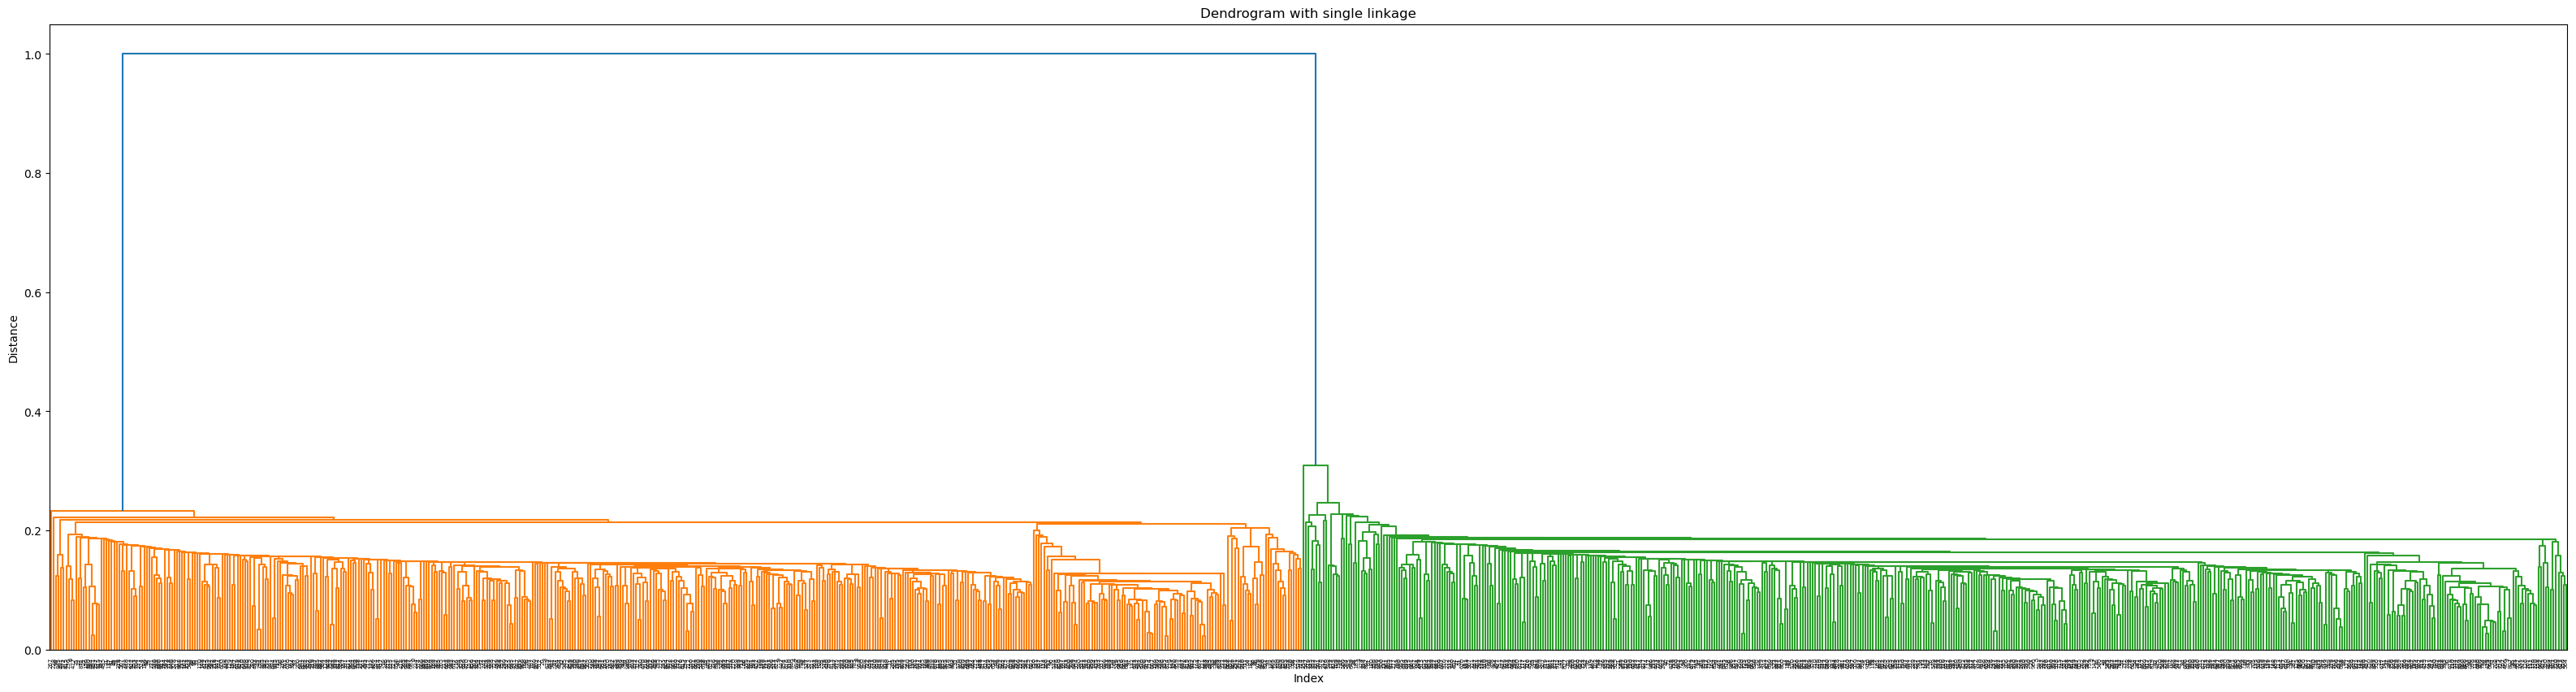

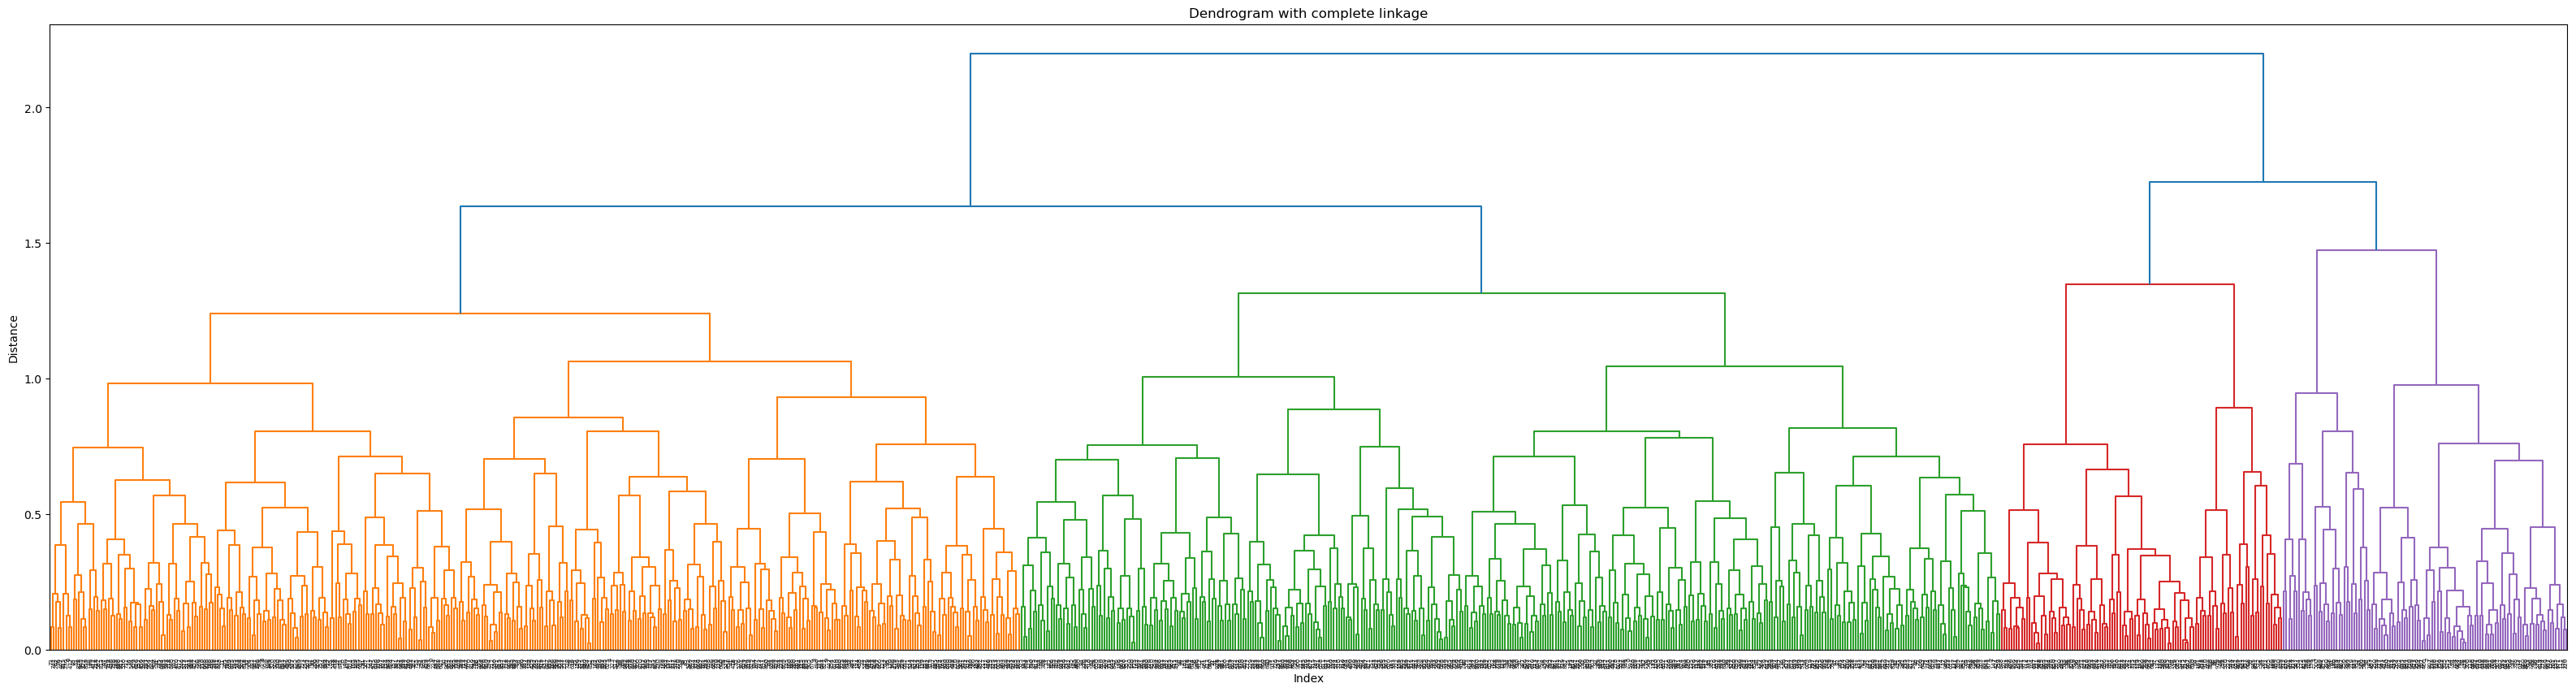

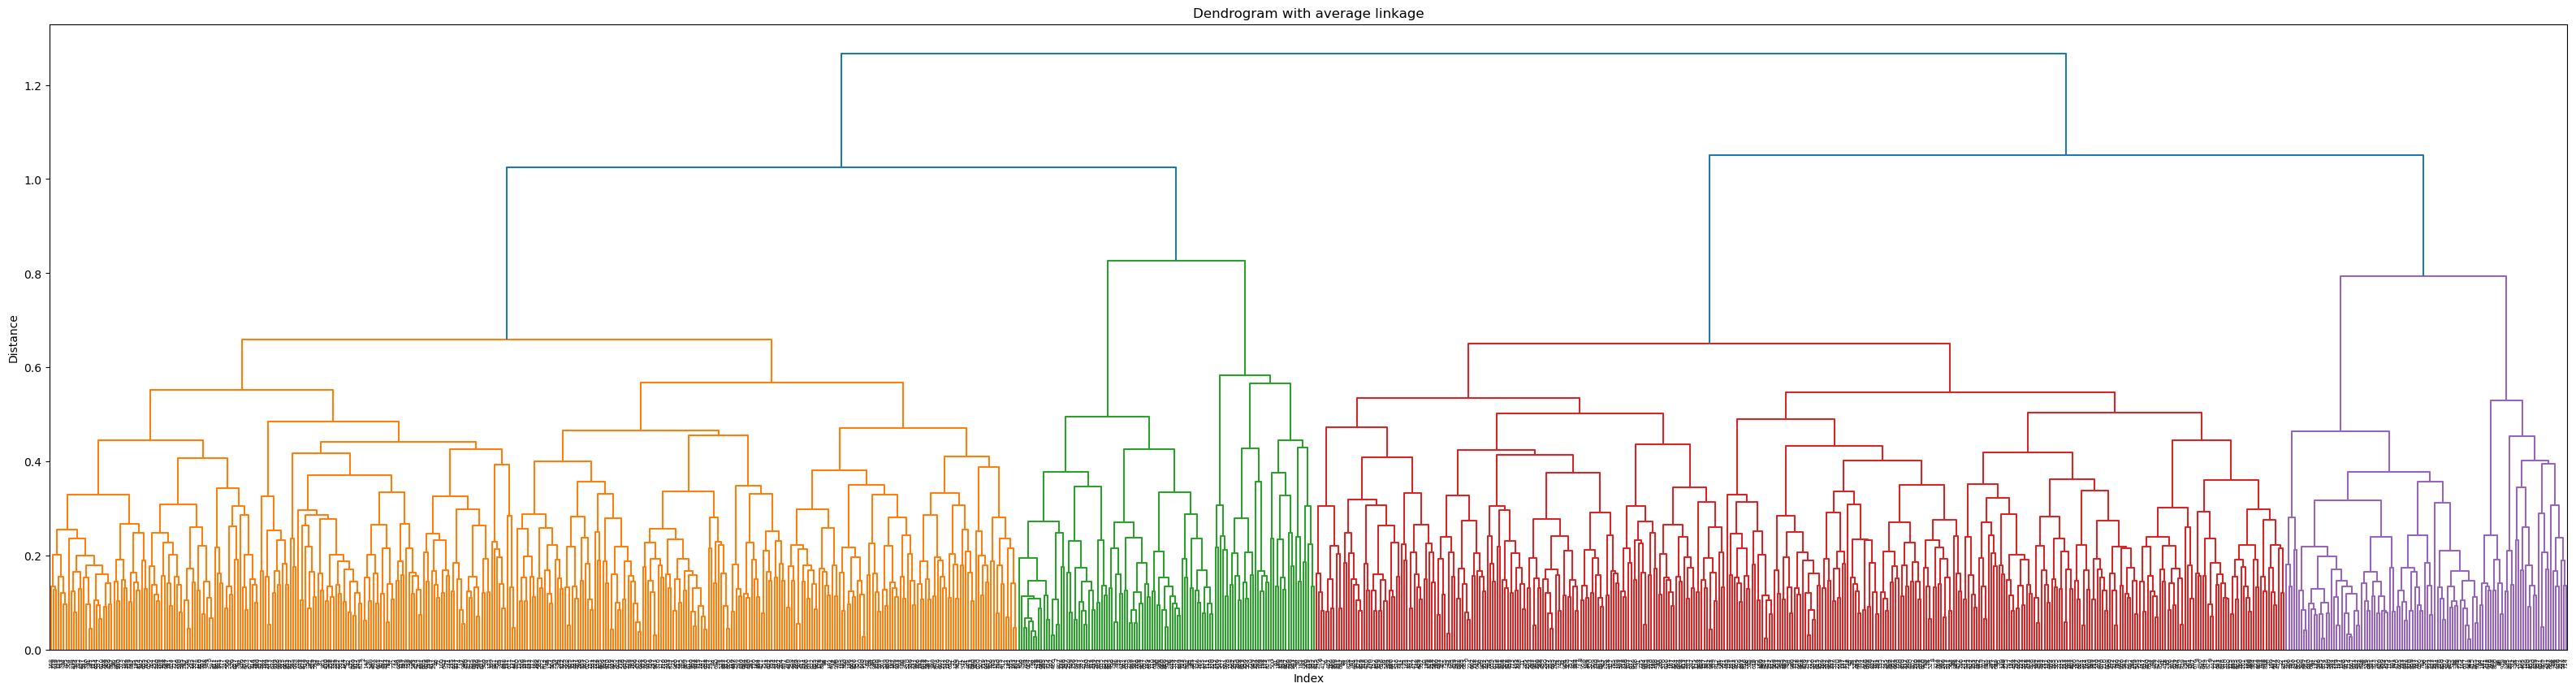

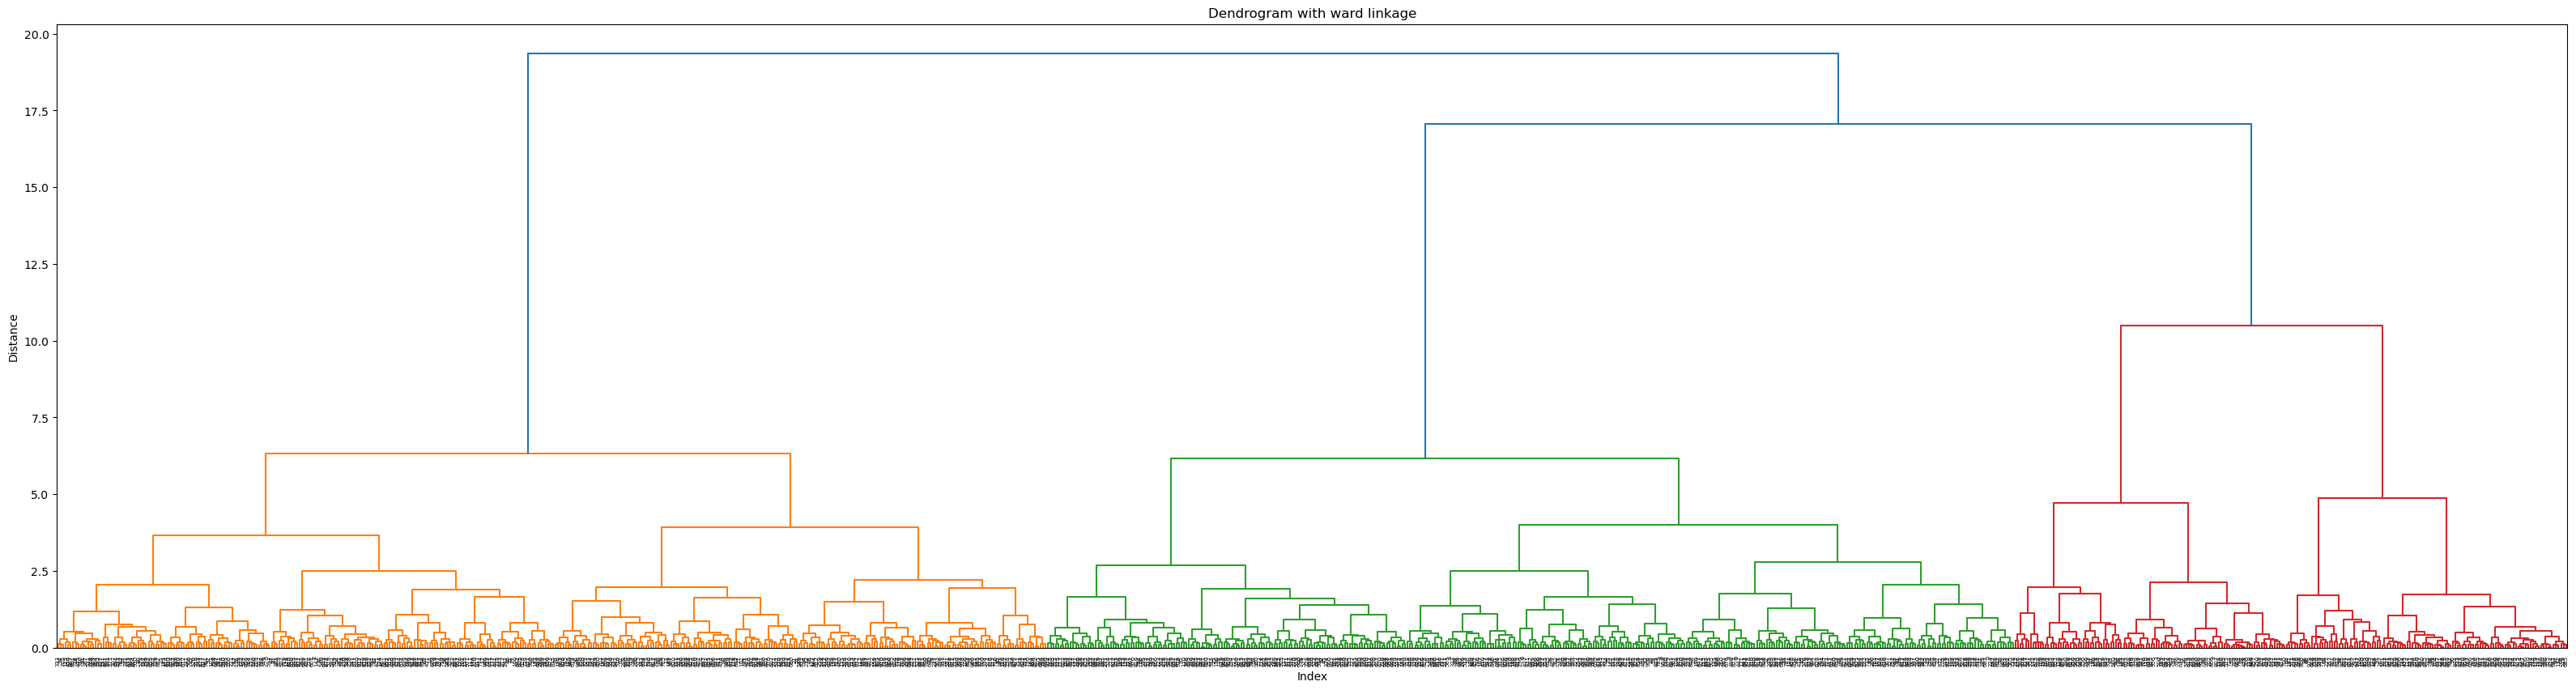

In [25]:
# full dendrogram with single linkage
plt.figure(figsize = (40, 10))
dendrogram(Z = dm_single)
plt.title('Dendrogram with single linkage')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

# full dendrogram with complete linkage
plt.figure(figsize = (40, 10))
dendrogram(Z = dm_complete)
plt.title('Dendrogram with complete linkage')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

# full dendrogram with average linkage
plt.figure(figsize = (40, 10))
dendrogram(Z = dm_average)
plt.title('Dendrogram with average linkage')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

# full dendrogram with ward linkage
plt.figure(figsize = (40, 10))
dendrogram(Z = dm_ward)
plt.title('Dendrogram with ward linkage')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

It is needed to create truncated dendrograms, just to see better the details

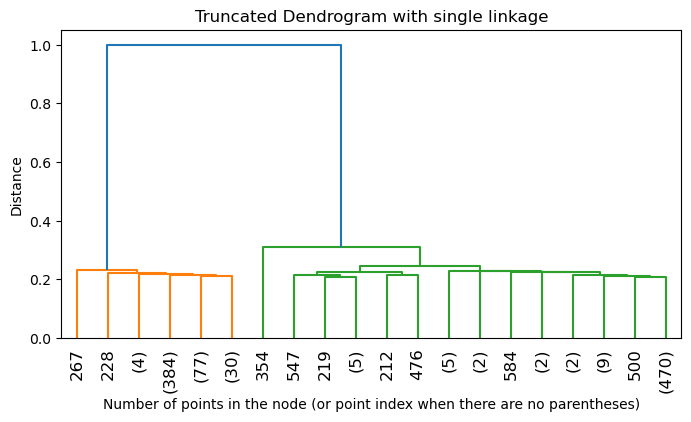

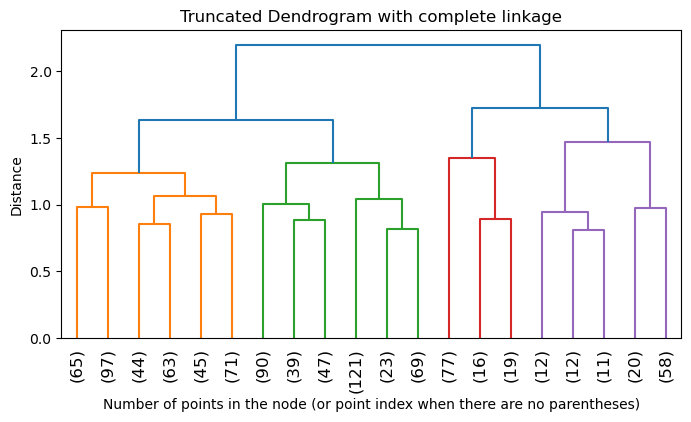

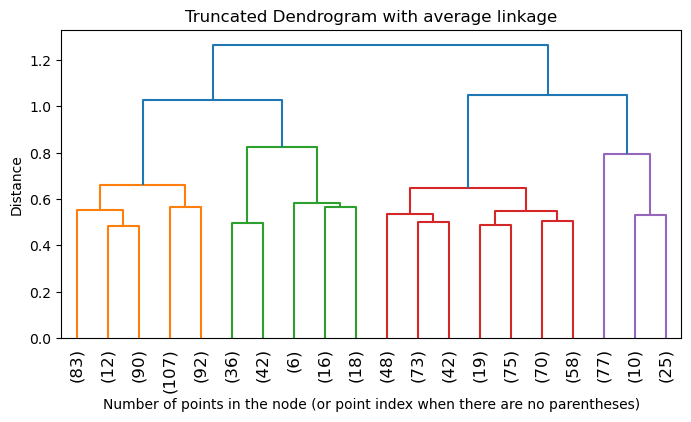

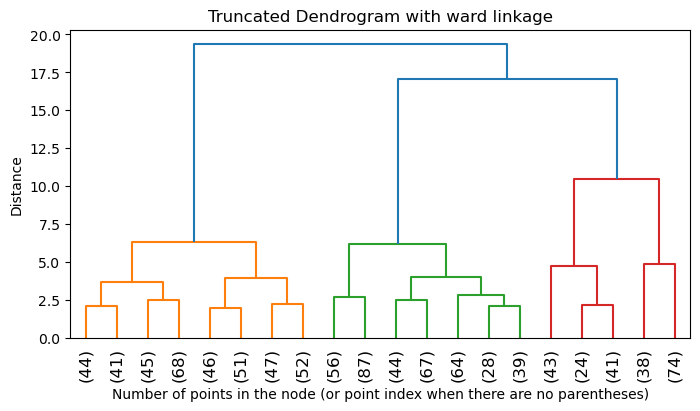

In [26]:
# truncated dendrogram with single linkage
plt.figure(figsize = (8, 4))
dendrogram(
    Z = dm_single,
    p = 20,
    truncate_mode = "lastp",
    leaf_rotation = 90.0
)
plt.title('Truncated Dendrogram with single linkage')
plt.xlabel('Number of points in the node (or point index when there are no parentheses)')
plt.ylabel('Distance')
plt.show()

# truncated dendrogram with complete linkage
plt.figure(figsize = (8, 4))
dendrogram(
    Z = dm_complete,
    p = 20,
    truncate_mode = "lastp",
    leaf_rotation = 90.0
)
plt.title('Truncated Dendrogram with complete linkage')
plt.xlabel('Number of points in the node (or point index when there are no parentheses)')
plt.ylabel('Distance')
plt.show()

# truncated dendrogram with average linkage
plt.figure(figsize = (8, 4))
dendrogram(
    Z = dm_average,
    p = 20,
    truncate_mode = "lastp",
    leaf_rotation = 90.0
)
plt.title('Truncated Dendrogram with average linkage')
plt.xlabel('Number of points in the node (or point index when there are no parentheses)')
plt.ylabel('Distance')
plt.show()

# truncated dendrogram with ward linkage
plt.figure(figsize = (8, 4))
dendrogram(
    Z = dm_ward,
    p = 20,
    truncate_mode = "lastp",
    leaf_rotation = 90.0
)
plt.title('Truncated Dendrogram with ward linkage')
plt.xlabel('Number of points in the node (or point index when there are no parentheses)')
plt.ylabel('Distance')
plt.show()

### Task 4. Determine the number of clusters or the distance threshold for cutting the dendrogram

<span style="color:red">**[TBC]**</span> Determine the number of clusters or the distance threshold using multiple clustering quality evaluation metrics.

#### Aglomerative Cluster

In [29]:
# Agglomerative Clustering 
model_single = AgglomerativeClustering(n_clusters = 5, linkage = 'single').fit(X)
model_complete = AgglomerativeClustering(n_clusters = 5, linkage = 'complete').fit(X)
model_average = AgglomerativeClustering(n_clusters = 5, linkage = 'average').fit(X)
model_ward = AgglomerativeClustering(n_clusters = 5, linkage = 'ward').fit(X)

In [30]:
# obtain clustering results
labeled_df = df.copy()
labeled_df['Cluster Single'] = model_single.labels_
labeled_df['Cluster Complete'] = model_complete.labels_
labeled_df['Cluster Average'] = model_average.labels_
labeled_df['Cluster Ward'] = model_ward.labels_
labeled_df.head()

Average Screen Time  Average Spent on App (INR)  Left Review  Ratings  \
0                 0.34                    0.635271          1.0      0.9   
1                 0.00                    0.054108          0.0      0.4   
2                 0.74                    0.207415          0.0      0.8   
3                 0.64                    0.445892          1.0      0.6   
4                 0.90                    0.427856          1.0      0.5   

   New Password Request  Last Visited Minutes  Cluster Single  \
0              0.428571              0.056328               4   
1              0.500000              0.480814               0   
2              0.285714              0.015551               0   
3              0.071429              0.012077               4   
4              0.357143              0.070021               4   

   Cluster Complete  Cluster Average  Cluster Ward  
0                 3                2             0  
1                 4                3             3  
2                 1                1             4  
3                 3                2             0  
4                 3                2             0

#### Optimal number of Clusters

In [31]:
# calculate the clustering quality evaluation metric
metric_df = pd.DataFrame(
    columns = ['Silhouette Coefficient', 'Calinski-Harabasz Index', 'Davies-Bouldin index'],
    index = ['Single', 'Complete', 'Average', 'Ward']
)
metric_df['Silhouette Coefficient'] = [
    silhouette_score(X, model_single.labels_),
    silhouette_score(X, model_complete.labels_),
    silhouette_score(X, model_average.labels_),
    silhouette_score(X, model_ward.labels_)
]
metric_df['Calinski-Harabasz Index'] = [
    calinski_harabasz_score(X, model_single.labels_),
    calinski_harabasz_score(X, model_complete.labels_),
    calinski_harabasz_score(X, model_average.labels_),
    calinski_harabasz_score(X, model_ward.labels_)
]
metric_df['Davies-Bouldin index'] = [
    davies_bouldin_score(X, model_single.labels_),
    davies_bouldin_score(X, model_complete.labels_),
    davies_bouldin_score(X, model_average.labels_),
    davies_bouldin_score(X, model_ward.labels_)
]
metric_df

Silhouette Coefficient  Calinski-Harabasz Index  \
Single                  0.314820               215.883207   
Complete                0.408966               581.605000   
Average                 0.400149               582.980065   
Ward                    0.353896               622.433371   

          Davies-Bouldin index  
Single                0.723949  
Complete              0.893267  
Average               0.903776  
Ward                  1.165903

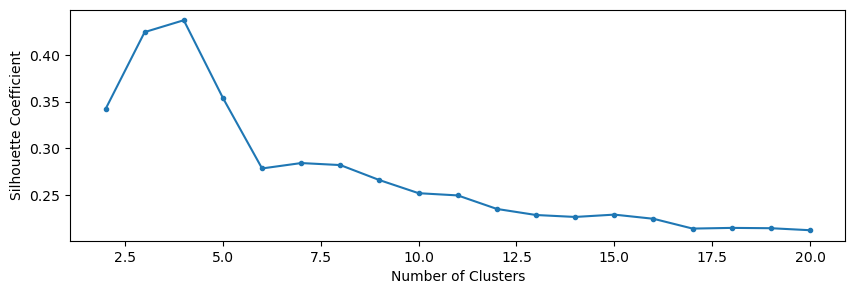

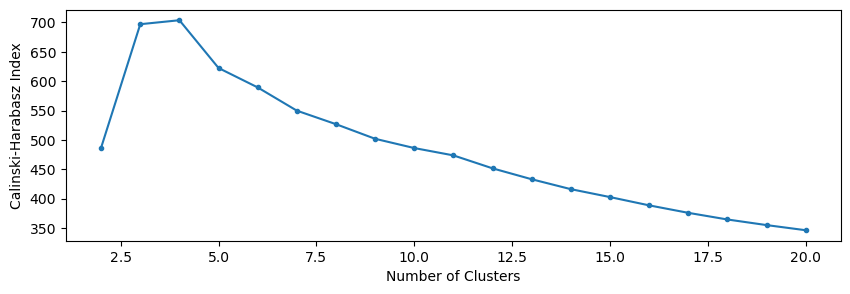

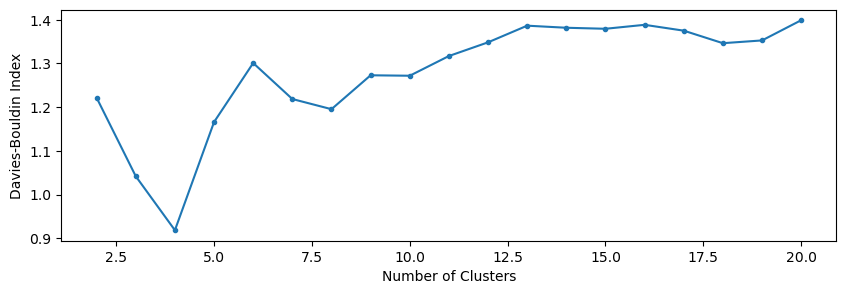

In [36]:
# create an empty list to store inertia
silhouette = []
calinski_harabasz = []
davies_bouldin = []
X = df

# test different number of clusters
for n_clusters in range(2, 21):  # Try different numbers of clusters
    model_ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(X)
    silhouette.append(silhouette_score(X, model_ward.labels_))
    calinski_harabasz.append(calinski_harabasz_score(X, model_ward.labels_))
    davies_bouldin.append(davies_bouldin_score(X, model_ward.labels_))

plt.figure(figsize=(10, 3))
plt.plot(range(2, 21), silhouette, '.-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(range(2, 21), calinski_harabasz, '.-')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(range(2, 21), davies_bouldin, '.-')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()

The optimal number of clusters showed is 4

### Task 5. Use the optimal distance threshold or number of clusters to perform agglomerative clustering and interpret the results

<span style="color:red">**[TBC]**</span> Use the conclusion of Task 4 to perform agglomerative clustering, explain the results.

In [37]:
# [TBC] complete your code here with proper comments
# Agglomerative Clustering 
model_single = AgglomerativeClustering(n_clusters = 4, linkage = 'single').fit(X)
model_complete = AgglomerativeClustering(n_clusters = 4, linkage = 'complete').fit(X)
model_average = AgglomerativeClustering(n_clusters = 4, linkage = 'average').fit(X)
model_ward = AgglomerativeClustering(n_clusters = 4, linkage = 'ward').fit(X)

In [38]:
# obtain clustering results
labeled_df = df.copy()
labeled_df['Cluster Single'] = model_single.labels_
labeled_df['Cluster Complete'] = model_complete.labels_
labeled_df['Cluster Average'] = model_average.labels_
labeled_df['Cluster Ward'] = model_ward.labels_
labeled_df.head()

Average Screen Time  Average Spent on App (INR)  Left Review  Ratings  \
0                 0.34                    0.635271          1.0      0.9   
1                 0.00                    0.054108          0.0      0.4   
2                 0.74                    0.207415          0.0      0.8   
3                 0.64                    0.445892          1.0      0.6   
4                 0.90                    0.427856          1.0      0.5   

   New Password Request  Last Visited Minutes  Cluster Single  \
0              0.428571              0.056328               0   
1              0.500000              0.480814               1   
2              0.285714              0.015551               1   
3              0.071429              0.012077               0   
4              0.357143              0.070021               0   

   Cluster Complete  Cluster Average  Cluster Ward  
0                 3                2             2  
1                 0                0             3  
2                 1                3             0  
3                 3                2             2  
4                 3                2             2

In [39]:
# get centroids of each clusters
# use the single linkage result as example
labeled_df[list(labeled_df.columns[:-3])].groupby(by = 'Cluster Single').mean()

Average Screen Time  Average Spent on App (INR)  Left Review  \
Cluster Single                                                                 
0                          0.482093                    0.418035          1.0   
1                          0.502602                    0.440289          0.0   
2                          0.000000                    0.042084          0.0   
3                          0.048889                    0.045870          0.0   

                 Ratings  New Password Request  Last Visited Minutes  
Cluster Single                                                        
0               0.652314              0.292900              0.098395  
1               0.656504              0.258566              0.084535  
2               0.500000              0.928571              0.442259  
3               0.333333              0.841270              0.903011

In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your dataset with 10 dimensions
# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(df)

# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_normalized)

In [47]:
# Fit the Agglomerative Clustering models
models = {
    'Single': AgglomerativeClustering(n_clusters=4, linkage='single').fit(X),
    'Complete': AgglomerativeClustering(n_clusters=4, linkage='complete').fit(X),
    'Average': AgglomerativeClustering(n_clusters=4, linkage='average').fit(X),
    'Ward': AgglomerativeClustering(n_clusters=4, linkage='ward').fit(X)
}

# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Single Linkage", "Complete Linkage", "Average Linkage", "Ward Linkage"),
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}],
           [{'type': 'scatter3d'}, {'type': 'scatter3d'}]]
)

# Plot the results
for i, (title, model) in enumerate(models.items()):
    row = (i // 2) + 1
    col = (i % 2) + 1
    trace = go.Scatter3d(
        x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color=model.labels_,                # set color to cluster labels
            colorscale='Viridis',
            opacity=0.8
        )
    )
    fig.add_trace(trace, row=row, col=col)

# Update layout
fig.update_layout(height=900, width=900, title_text="Agglomerative Clustering with Different Linkage Methods")
fig.show()

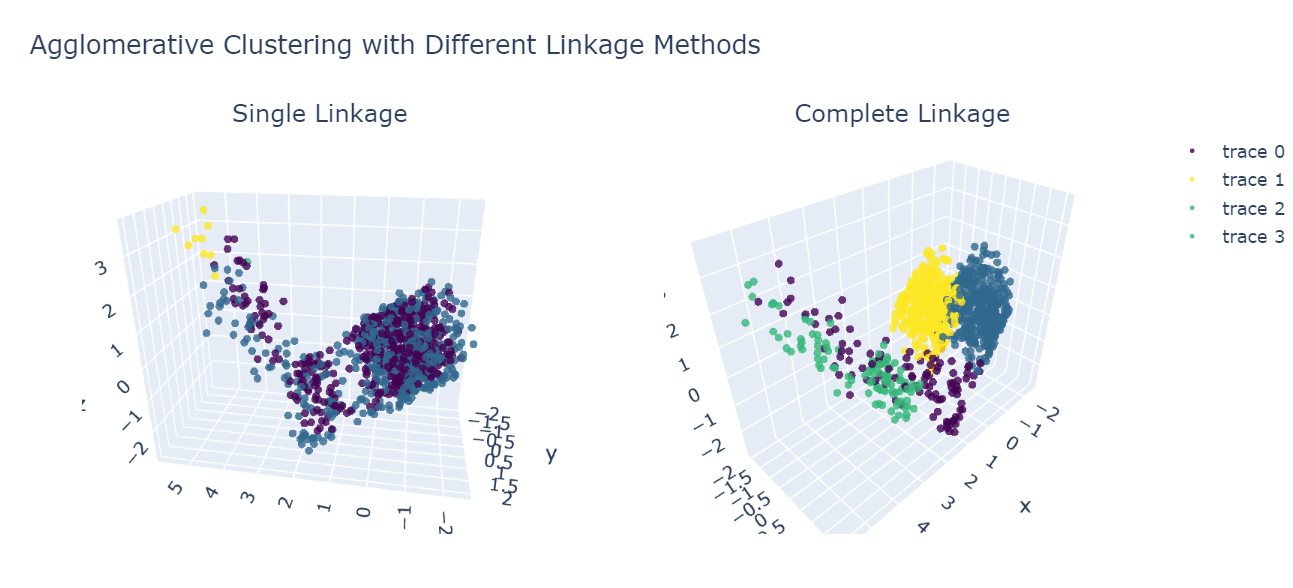
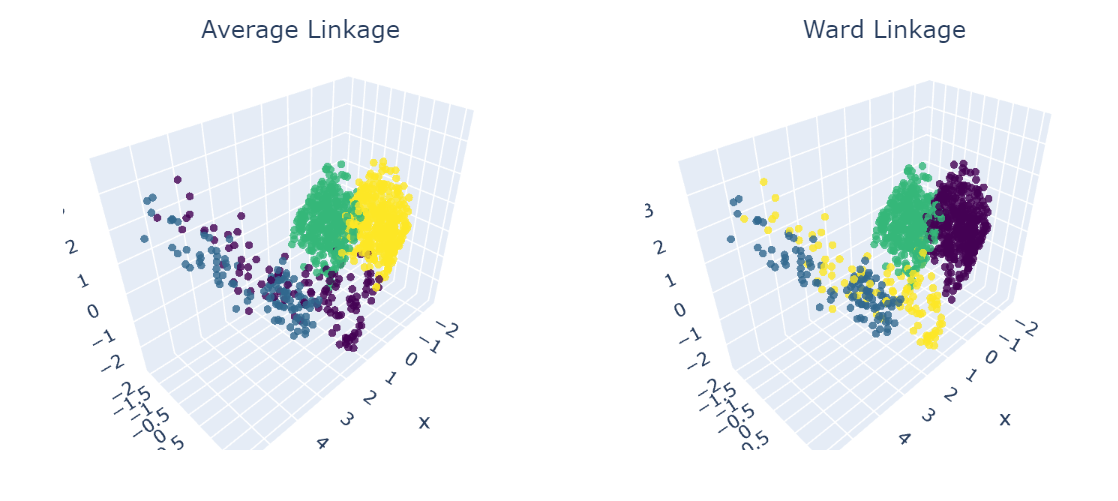